In [1]:
import pandas as pd
import numpy as np

In [2]:
comments=pd.read_csv('Tweet_cmt.csv')
df=pd.read_csv('MeTooMMD_train.csv')

In [3]:
MeToo = df[df['TweetId'].isin(comments['Id'])]

In [4]:
MeToo.head()

,TweetId,Text_Only_Informative,Image_Only_Informative,Directed_Hate,Generalized_Hate,Sarcasm,Allegation,Justification,Refutation,Support,Oppose
0,1052237153789390853,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1052207832081129472,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1052183746344960000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1052095305133510656,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,1052046529320640512,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [5]:
comments.shape

(6867, 2)

In [6]:
comments.head()

,Id,Comments
0,1051939199195045890,What shock hey Old Bill is in the clear amp ev...
1,1050811961011838977,No Bucky people are pissed off at ashleyperkin...
2,1049930526314782720,If Sarah Hanson Young thinks BrettKavanuagh is...
3,1051661466837901313,days million tweets One powerful movement Tod...
4,1051356183402033152,HimToo how an attempt to criticize MeToo went...


In [7]:
MeToo_labels = MeToo[["Text_Only_Informative", "Image_Only_Informative", "Directed_Hate",\
                         "Generalized_Hate", "Sarcasm", "Allegation", "Justification", "Refutation", \
                        "Support", "Oppose"]]
MeToo_labels.shape
class_names = ["Text_Only_Informative", "Image_Only_Informative", "Directed_Hate",\
                         "Generalized_Hate", "Sarcasm", "Allegation", "Justification", "Refutation", \
                        "Support", "Oppose"]

In [8]:
import re
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

X = []
sentences = list(comments["Comments"])
for sen in sentences:
    X.append(preprocess_text(sen))

In [9]:
y = MeToo_labels.values

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
np.shape(X_train)

(5493,)

In [11]:
from zeugma.embeddings import EmbeddingTransformer
gloves = EmbeddingTransformer('glove')
X_train_glove = gloves.transform(X_train)

Using TensorFlow backend.


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
neighbors = list(range(1, 50, 2))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_glove, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 49


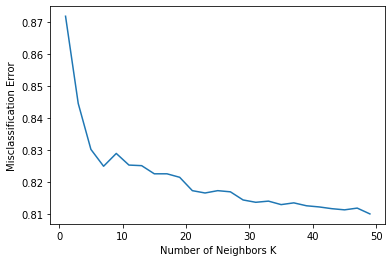

In [13]:
import matplotlib.pyplot as plt
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()

In [14]:
target_labels = pd.DataFrame(y_train, columns = [["Text_Only_Informative", "Image_Only_Informative", "Directed_Hate",\
                         "Generalized_Hate", "Sarcasm", "Allegation", "Justification", "Refutation", \
                        "Support", "Oppose"]])
target_labels.to_csv('target.csv', index=False)
target_output=pd.read_csv('target.csv')

In [15]:
from sklearn.neighbors import KNeighborsRegressor
X_test_glove = gloves.transform(X_test)
score=[]
for class_name in class_names:
    train_target=target_output[class_name]
    model = KNeighborsRegressor(n_neighbors=3)
    model.fit(X_train_glove, train_target)
    print('Training KNeighborRegressor for {} is complete!!'.format(class_name))
    submission=model.predict(X_test_glove)
    
    for pred in submission:
        if pred>=0.5:
            score.append(1)            
        else:
            score.append(0)          
    

Training KNeighborRegressor for Text_Only_Informative is complete!!
Training KNeighborRegressor for Image_Only_Informative is complete!!
Training KNeighborRegressor for Directed_Hate is complete!!
Training KNeighborRegressor for Generalized_Hate is complete!!
Training KNeighborRegressor for Sarcasm is complete!!
Training KNeighborRegressor for Allegation is complete!!
Training KNeighborRegressor for Justification is complete!!
Training KNeighborRegressor for Refutation is complete!!
Training KNeighborRegressor for Support is complete!!
Training KNeighborRegressor for Oppose is complete!!


In [26]:
newarr=np.reshape(score,(1374,10))
#y_train_resape=np.reshape(y_train,(5493,10))

In [29]:
#np.shape(y_train_resape)

(5493, 10)

In [18]:
#y = MeToo.values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.29, random_state=42)
#np.shape(y_test)

In [19]:
predictions = pd.DataFrame(newarr, columns = [["Text_Only_Informative", "Image_Only_Informative", "Directed_Hate",\
                         "Generalized_Hate", "Sarcasm", "Allegation", "Justification", "Refutation", \
                        "Support", "Oppose"]])

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.77      0.14      0.23       999
           1       0.33      0.15      0.20       451
           2       0.04      0.15      0.06        48
           3       0.03      0.16      0.05        37
           4       0.01      0.08      0.02        25
           5       0.08      0.17      0.11        82
           6       0.03      0.14      0.05        43
           7       0.00      0.00      0.00        35
           8       0.36      0.15      0.21       437
           9       0.09      0.13      0.10       116

   micro avg       0.17      0.14      0.16      2273
   macro avg       0.17      0.13      0.10      2273
weighted avg       0.48      0.14      0.20      2273
 samples avg       0.06      0.11      0.07      2273



/home/mohsin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mohsin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 

Before OverSampling, counts of label '1': [3989 1819  209  157  121  283  187  107 1752  389]
Before OverSampling, counts of label '0': [1504 3674 5284 5336 5372 5210 5306 5386 3741 5104] 



In [33]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
score=[]
for class_name in class_names:
    train_target=target_output[class_name]
    X_train_res, y_train_res = sm.fit_sample(X_train_glove, train_target.ravel())
    print('Balancing for {} is complete!!'.format(class_name))
         

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Balancing for Text_Only_Informative is complete!!
Balancing for Image_Only_Informative is complete!!
Balancing for Directed_Hate is complete!!
Balancing for Generalized_Hate is complete!!
Balancing for Sarcasm is complete!!
Balancing for Allegation is complete!!
Balancing for Justification is complete!!
Balancing for Refutation is complete!!
Balancing for Support is complete!!
Balancing for Oppose is complete!!
After OverSampling, the shape of train_X: (10208, 25)
After OverSampling, the shape of train_y: (10208,) 

After OverSampling, counts of label '1': 5104
After OverSampling, counts of label '0': 5104


In [35]:
from sklearn.neighbors import KNeighborsRegressor
score=[]
for class_name in class_names:
   
    model = KNeighborsRegressor(n_neighbors=3)
    model.fit(X_train_res, y_train_res)
    print('Training KNeighborRegressor for {} is complete!!'.format(class_name))
    submission=model.predict(X_test_glove)
    
    for pred in submission:
        if pred>=0.5:
            score.append(1)            
        else:
            score.append(0) 

Training KNeighborRegressor for Text_Only_Informative is complete!!
Training KNeighborRegressor for Image_Only_Informative is complete!!
Training KNeighborRegressor for Directed_Hate is complete!!
Training KNeighborRegressor for Generalized_Hate is complete!!
Training KNeighborRegressor for Sarcasm is complete!!
Training KNeighborRegressor for Allegation is complete!!
Training KNeighborRegressor for Justification is complete!!
Training KNeighborRegressor for Refutation is complete!!
Training KNeighborRegressor for Support is complete!!
Training KNeighborRegressor for Oppose is complete!!


In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.77      0.14      0.23       999
           1       0.33      0.15      0.20       451
           2       0.04      0.15      0.06        48
           3       0.03      0.16      0.05        37
           4       0.01      0.08      0.02        25
           5       0.08      0.17      0.11        82
           6       0.03      0.14      0.05        43
           7       0.00      0.00      0.00        35
           8       0.36      0.15      0.21       437
           9       0.09      0.13      0.10       116

   micro avg       0.17      0.14      0.16      2273
   macro avg       0.17      0.13      0.10      2273
weighted avg       0.48      0.14      0.20      2273
 samples avg       0.06      0.11      0.07      2273



In [34]:
from imblearn.under_sampling import NearMiss 
nr = NearMiss() 
  
X_train_miss, y_train_miss = nr.fit_sample(X_train_glove, y_train.ravel()) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0))) 


ValueError: Found input variables with inconsistent numbers of samples: [5493, 54930]

In [39]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1374 entries, 0 to 1373
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   (Text_Only_Informative,)   1374 non-null   int64
 1   (Image_Only_Informative,)  1374 non-null   int64
 2   (Directed_Hate,)           1374 non-null   int64
 3   (Generalized_Hate,)        1374 non-null   int64
 4   (Sarcasm,)                 1374 non-null   int64
 5   (Allegation,)              1374 non-null   int64
 6   (Justification,)           1374 non-null   int64
 7   (Refutation,)              1374 non-null   int64
 8   (Support,)                 1374 non-null   int64
 9   (Oppose,)                  1374 non-null   int64
dtypes: int64(10)
memory usage: 107.5 KB


In [34]:
tweetIds=[]
tweetIds=y_test[:,0]
tweetIds
tweetIds = tweetIds.astype('Int64') 

/home/mohsin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  after removing the cwd from sys.path.


In [35]:
predictions.insert(0, "TweetId", tweetIds , True)

In [36]:
predictions.to_csv('predictions.csv', index=False)

In [37]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   (TweetId,)                 1992 non-null   int64
 1   (Text_Only_Informative,)   1992 non-null   int64
 2   (Image_Only_Informative,)  1992 non-null   int64
 3   (Directed_Hate,)           1992 non-null   int64
 4   (Generalized_Hate,)        1992 non-null   int64
 5   (Sarcasm,)                 1992 non-null   int64
 6   (Allegation,)              1992 non-null   int64
 7   (Justification,)           1992 non-null   int64
 8   (Refutation,)              1992 non-null   int64
 9   (Support,)                 1992 non-null   int64
 10  (Oppose,)                  1992 non-null   int64
dtypes: int64(11)
memory usage: 171.3 KB


In [40]:
predictions.head()

,Text_Only_Informative,Image_Only_Informative,Directed_Hate,Generalized_Hate,Sarcasm,Allegation,Justification,Refutation,Support,Oppose
0,1,1,1,1,0,1,1,1,0,0
1,1,1,1,1,1,1,1,1,1,1
2,0,1,1,0,1,1,1,1,1,1
3,1,1,0,0,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1


In [39]:
predictions.describe()

,TweetId,Text_Only_Informative,Image_Only_Informative,Directed_Hate,Generalized_Hate,Sarcasm,Allegation,Justification,Refutation,Support,Oppose
count,1.992000e+03,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.00000
mean,1.052699e+18,0.136044,0.135542,0.132530,0.133534,0.140562,0.129016,0.134036,0.128514,0.135542,0.13002
std,2.091083e+15,0.342922,0.342388,0.339151,0.340237,0.347657,0.335302,0.340777,0.334745,0.342388,0.33641
min,1.048548e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.051115e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.052132e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.054627e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,1.059517e+18,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
